##### Copyright 2018 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Image classification

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/classification"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/classification.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/images/classification.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

このチュートリアルでは、`tf.keras.Sequential`モデルを使って花の画像を分類し、`tf.keras.utils.image_dataset_from_directory`を使ってデータをロードする方法を説明します。以下のコンセプトを実証しています。


* ディスクからデータセットを効率的にロードする。
* オーバーフィットを特定し、それを軽減するためにデータ増強とドロップアウトを含む技術を適用する。

このチュートリアルは、基本的な機械学習のワークフローに従います。

1. データを調査し理解する
2. 入力パイプラインの構築
3. モデルの構築
4. モデルの学習
5. モデルのテスト
6. モデルを改良し、そのプロセスを繰り返す

さらに、このノートブックでは、モバイル、組み込み、IoTデバイスのオンデバイス機械学習のために、[saved model](../../guide/saved_model.ipynb) を [TensorFlow Lite](https://www.tensorflow.org/lite/) モデルに変換する方法を示しています。



In [1]:
#グーグルドライブと同期
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## セットアップ

TensorFlowやその他必要なライブラリをインポートします。

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## データセットのダウンロードとチェック

このチュートリアルでは、約2831枚のダニの写真からなるデータセットを使用します。このデータセットには３つのサブディレクトリがあり、クラスごとに1つずつあります。
```
mitedataset/
  devidedmite/
  mite/
  notmite/

```

In [3]:
#★driveから持ってくるsutemeru13にある
import shutil
import pathlib
shutil.copy('/content/drive/MyDrive/mitedataset.zip','/content/mitedataset.zip')
shutil.unpack_archive("/content/mitedataset.zip", "/content")
data_dir = pathlib.Path('/content/mitedataset')

ダウンロード後、データセットのコピーが利用できるようになるはずです。合計2,821枚の画像があります。

In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

2831


ダニがいる画像は

915 枚


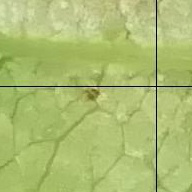

In [5]:
mite = list(data_dir.glob('mite/*'))
print(len(mite),"枚")
PIL.Image.open(str(mite[0]))

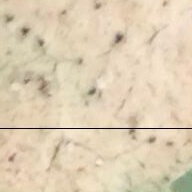

In [6]:
PIL.Image.open(str(mite[1]))

ダニがいない画像は

1706 枚


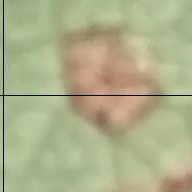

In [7]:
notmite = list(data_dir.glob('notmite/*'))
print(len(notmite),"枚")
PIL.Image.open(str(notmite[0]))

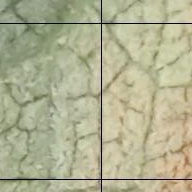

In [8]:
PIL.Image.open(str(notmite[1]))

## Kerasユーティリティを使用してデータをロードする

次に、有用な `tf.keras.utils.image_dataset_from_directory` ユーティリティを使用してディスクからこれらの画像をロードします。これは、数行のコードで、ディスク上の画像のディレクトリから `tf.data.Dataset` に移動させます。もしよろしければ、[Load and preprocess images](../load_data/images.ipynb) tutorialをご覧いただき、ゼロからご自身のデータ読み込みコードを書くことも可能です。

### データセットの作成



ローダーに関するいくつかのパラメータを定義します。

In [10]:
batch_size = 2
img_height = 192
img_width = 192

モデルを開発する際には、検証用のスプリットを使用するのがよいでしょう。80%の画像をトレーニングに、20%の画像を検証に使用します。

In [11]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2831 files belonging to 3 classes.
Using 2265 files for training.


In [12]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2831 files belonging to 3 classes.
Using 566 files for validation.


これらのデータセットの `class_names` 属性に、クラス名が記載されています。これらは、アルファベット順のディレクトリ名に対応しています。

In [13]:
class_names = train_ds.class_names
print(class_names)

['devidedmite', 'mite', 'notmite']


## データを可視化する

トレーニングデータセットの最初の9枚の画像です。

注：バッチサイズが２なら２つまでしか表記できない



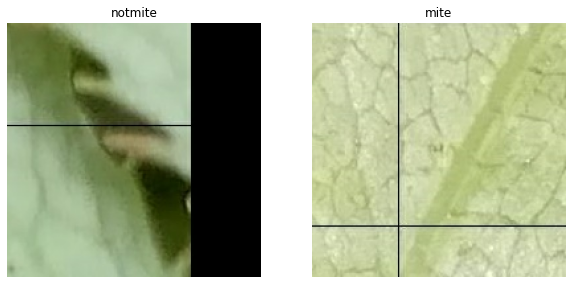

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(2):
    ax = plt.subplot(1, 2, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

このチュートリアルの後半で、これらのデータセットをKerasの `Model.fit` メソッドに渡して学習させることになります。必要であれば、手動でデータセットを繰り返し、画像のバッチを取得することもできます。

In [17]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(2, 192, 192, 3)
(2,)


`image_batch` は `(2, 192, 192, 3)` 形式のテンソルである。これは `192x192x3` 形状の2枚の画像のバッチである (最後の次元はカラーチャンネルRGBを参照する)。label_batch` は `(2,)形式のテンソルであり、2枚の画像に対応するラベルを表します。

image_batch`と`labels_batch`のテンソルに対して `.numpy()` を呼び出すと、 `numpy.ndarray` に変換することができます。


## パフォーマンスのためのデータセットの設定

バッファード・プリフェッチを必ず使用し、I/Oがブロック化されることなくディスクからデータを取得できるようにします。この2つは、データを読み込むときに使うべき重要な方法です。

- `Dataset.cache` は、最初のエポック時にディスクから読み込まれた画像をメモリ上に保持します。これにより、モデルの学習中にデータセットがボトルネックになることはありません。データセットが大きすぎてメモリに収まらない場合は、この方法を用いてパフォーマンスの高いオンディスクキャッシュを作成することもできます。
- `Dataset.prefetch` は学習中のデータの前処理とモデルの実行をオーバーラップさせます。

この2つのメソッドについて、またデータをディスクにキャッシュする方法については、[Better performance with the tf.data API](../../guide/data_performance.ipynb) ガイドの *Prefetching* セクションで詳しく説明されているので、興味のある読者は参照してください。

In [18]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## データの標準化

RGB チャンネルの値は `[0, 255]` の範囲にあります。これはニューラルネットワークにとって理想的ではありません。一般的には、入力値を小さくすることを追求すべきです。

ここでは、`tf.keras.lays.Rescaling`を使用して、`[0, 1]`の範囲になるように値を標準化します。

In [ ]:
normalization_layer = layers.Rescaling(1./255)

このレイヤーを使うには2つの方法があります。データセットに適用するには、`Dataset.map`を呼び出します。

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.82745105


または、モデル定義の中にレイヤーを含めることができ、デプロイメントを簡素化することができます。ここでは、2番目のアプローチを使用します。

注意：以前は `tf.keras.utils.image_dataset_from_directory` の `image_size` 引数を用いて画像のリサイズを行いました。もし、リサイズロジックもモデルに含めたい場合は、`tf.keras.lays.Resizing`レイヤーを使用することが可能です。

## 基本的なKerasモデル

### モデルの作成

Keras [Sequential](https://www.tensorflow.org/guide/keras/sequential_model) モデルは、3つのコンボリューションブロック (`tf.keras.layers.Conv2D`) とそれぞれの中の最大プーリング層 (`tf.keras.layers.MaxPooling2D`) から構成されています。その上に128個のユニットを持つ完全連結層(`tf.keras.lays.Dense`)があり、ReLU活性化関数(`relu'`)で活性化されています。このモデルは高精度のためにチューニングされていません。このチュートリアルの目的は、標準的なアプローチを示すことです。

In [91]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.MaxPooling2D(pool_size=(8, 2),padding='same'),
  layers.DepthwiseConv2D((1, 2), padding='same', activation='relu'),
  layers.Dropout(0.4),
  layers.Flatten(),  
  layers.Dense(num_classes, activation='softmax'),  
])

### モデルのコンパイル

このチュートリアルでは、`tf.keras.optimizers.Adam` オプティマイザと `tf.keras.losses.SparseCategoricalCrossentropy` 損失関数を選択します。各トレーニングエポックのトレーニング精度と検証精度を表示するには、`Model.compile` に `metrics` 引数を渡します。

In [92]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',              
              metrics=['accuracy'])

### モデルの要約

Keras の `Model.summary` メソッドを使用して、ネットワークの全レイヤーを表示します。

In [93]:
model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_21 (Rescaling)    (None, 192, 192, 3)       0         
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 24, 96, 3)        0         
 g2D)                                                            
                                                                 
 depthwise_conv2d_21 (Depthw  (None, 24, 96, 3)        9         
 iseConv2D)                                                      
                                                                 
 dropout_1 (Dropout)         (None, 24, 96, 3)         0         
                                                                 
 flatten_14 (Flatten)        (None, 6912)              0         
                                                                 
 dense_38 (Dense)            (None, 3)               

### モデルのトレーニング

Kerasの`Model.fit`メソッドで10エポック分のモデルを学習させます。

In [94]:
epochs=100
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/100
1133/1133 [==============================] - 4s 3ms/step - loss: 0.9953 - accuracy: 0.5479 - val_loss: 0.8857 - val_accuracy: 0.6060
Epoch 2/100
1133/1133 [==============================] - 4s 3ms/step - loss: 0.8652 - accuracy: 0.6084 - val_loss: 0.8215 - val_accuracy: 0.5936
Epoch 3/100
1133/1133 [==============================] - 3s 3ms/step - loss: 0.8087 - accuracy: 0.6305 - val_loss: 0.7674 - val_accuracy: 0.5954
Epoch 4/100
1133/1133 [==============================] - 3s 3ms/step - loss: 0.7543 - accuracy: 0.6464 - val_loss: 0.7193 - val_accuracy: 0.7173
Epoch 5/100
1133/1133 [==============================] - 3s 3ms/step - loss: 0.7182 - accuracy: 0.6521 - val_loss: 0.6718 - val_accuracy: 0.7297
Epoch 6/100
1133/1133 [==============================] - 3s 3ms/step - loss: 0.6838 - accuracy: 0.6843 - val_loss: 0.6501 - val_accuracy: 0.7350
Epoch 7/100
1133/1133 [==============================] - 3s 3ms/step - loss: 0.6572 - accuracy: 0.7029 - val_loss: 0.6521 - val_ac

## トレーニング結果の可視化

トレーニングセットとバリデーションセットの損失と精度のプロットを作成します。

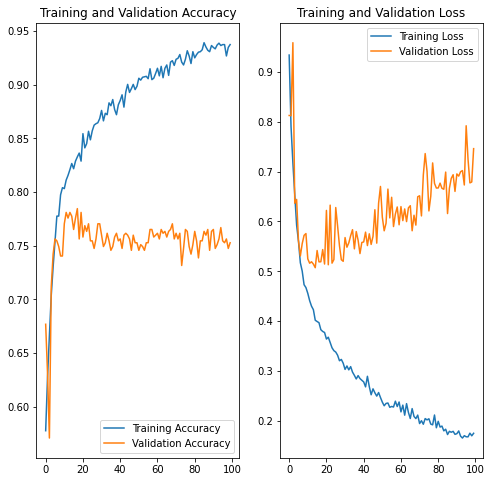

In [90]:
#layers.Dropout(0.2),
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

プロットは、トレーニング精度と検証精度が大きくずれており、モデルは検証セットで60%程度の精度しか達成できていないことを示しています。

以下のチュートリアルでは、何が問題だったのかを検証し、モデルの全体的なパフォーマンスを向上させる方法を説明します。

## オーバーフィット

上のプロットでは、学習精度が時間とともに直線的に上昇しているのに対し、検証精度は学習過程の60%付近で停滞しています。また、学習精度と検証精度の差が顕著であり、[overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit)の兆候が見られます。

学習例が少ない場合、モデルは学習例からノイズや不要な部分を学習し、それが新しい例に対するモデルの性能に悪影響を与えることがあります。このような現象はオーバーフィットと呼ばれます。これは、モデルが新しいデータセットで汎化するのが難しくなることを意味します。

学習プロセスにおいてオーバーフィットに対抗する方法は複数あります。このチュートリアルでは、*data augmentation*を使用し、*dropout*をモデルに追加します。

## データ拡張

一般的にオーバーフィッティングは、学習例が少ない場合に発生します。[Data augmentation](./data_augmentation.ipynb) は、既存の学習データから、信頼できそうな画像を生成するランダムな変換を使用して学習データを追加生成するアプローチを取ります。これにより、モデルがデータのより多くの側面に触れ、より良く汎化することができます。

以下のKerasの前処理レイヤーを使用してデータ増強を実装します：`tf.keras.lays.RandomFlip`, `tf.keras.layers.RandomRotation`, そして `tf.keras.lays.RandomZoom`。これらは他のレイヤーのようにモデル内に含めることができ、GPU上で実行することができます。

In [103]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

同じ画像に何度かデータ補強を施して、補強した例をビジュアル化します。

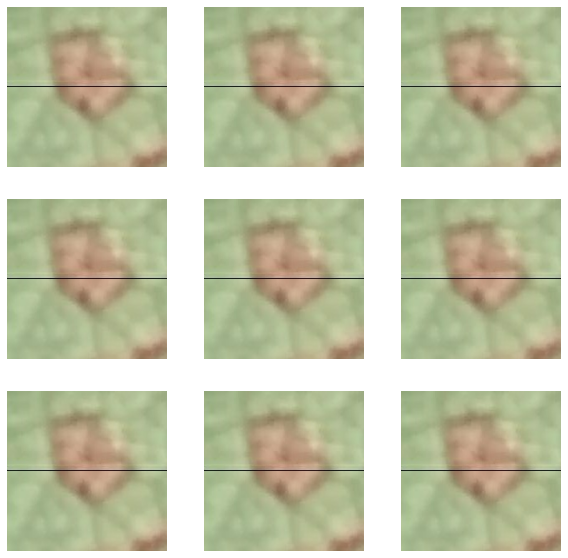

In [106]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

次のステップでトレーニングする前に、モデルにデータ拡張を追加します。

## ドロップアウト

オーバーフィッティングを減らすもう一つの手法は、ネットワークに [dropout](https://developers.google.com/machine-learning/glossary#dropout_regularization){:.external} 正則化を導入することである。

ドロップアウトを適用すると、学習中にレイヤーからランダムに出力ユニットが（活性化をゼロにして）ドロップアウトされます。ドロップアウトは0.1、0.2、0.4などの小数値を入力値として受け取ります。これは、適用された層からランダムに10％、20％、40％の出力ユニットをドロップアウトすることを意味します。

新しいニューラルネットワークを `tf.keras.layers.Dropout` で作成してから、拡張された画像を使ってトレーニングします。

In [107]:
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.MaxPooling2D(pool_size=(8, 2),padding='same'),
  layers.DepthwiseConv2D((1, 2), padding='same', activation='relu'),
  layers.Dropout(0.2),
  layers.Flatten(),  
  layers.Dense(num_classes, activation='softmax'),  
])

In [ ]:
#もともと
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

## モデルのコンパイルと学習

In [108]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [109]:
model.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_25 (Sequential)  (None, 192, 192, 3)       0         
                                                                 
 rescaling_22 (Rescaling)    (None, 192, 192, 3)       0         
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 24, 96, 3)        0         
 g2D)                                                            
                                                                 
 depthwise_conv2d_22 (Depthw  (None, 24, 96, 3)        9         
 iseConv2D)                                                      
                                                                 
 dropout_2 (Dropout)         (None, 24, 96, 3)         0         
                                                                 
 flatten_15 (Flatten)        (None, 6912)            

In [112]:
epochs = 100
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/100
1133/1133 [==============================] - 8s 7ms/step - loss: 0.6746 - accuracy: 0.6874 - val_loss: 0.5978 - val_accuracy: 0.7367
Epoch 2/100
1133/1133 [==============================] - 6s 5ms/step - loss: 0.6836 - accuracy: 0.6693 - val_loss: 0.6655 - val_accuracy: 0.7067
Epoch 3/100
1133/1133 [==============================] - 7s 6ms/step - loss: 0.6766 - accuracy: 0.6804 - val_loss: 0.7166 - val_accuracy: 0.6678
Epoch 4/100
1133/1133 [==============================] - 9s 8ms/step - loss: 0.6755 - accuracy: 0.6905 - val_loss: 0.5943 - val_accuracy: 0.7438
Epoch 5/100
1133/1133 [==============================] - 6s 5ms/step - loss: 0.6693 - accuracy: 0.6826 - val_loss: 0.6072 - val_accuracy: 0.7420
Epoch 6/100
1133/1133 [==============================] - 6s 5ms/step - loss: 0.6761 - accuracy: 0.6909 - val_loss: 0.5847 - val_accuracy: 0.7385
Epoch 7/100
1133/1133 [==============================] - 6s 5ms/step - loss: 0.6741 - accuracy: 0.6826 - val_loss: 0.5923 - val_ac

## 学習結果の可視化

データ拡張と `tf.keras.layers.Dropout` を適用した結果、オーバーフィットが以前より減少し、学習と検証の精度がより一致するようになりました。

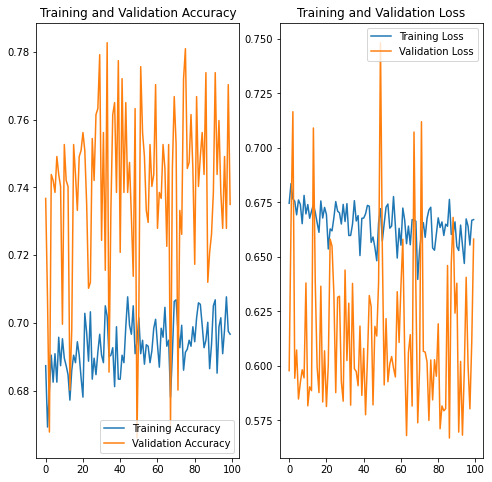

In [113]:
#RandomRotation(0.5)は大きすぎ
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## 新しいデータで予測する

トレーニングセットやバリデーションセットに含まれていない画像を、モデルを使って分類します。

注：データ補強層とドロップアウト層は推論時には非活性である。

In [ ]:
#★テスト画像をダウンロード
!wget -O "/content/Red_sunflower.jpg" "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = pathlib.Path('/content//Red_sunflower.jpg')
#sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
#sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

--2022-12-13 13:52:53--  https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.200.128, 74.125.68.128, 142.250.4.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.200.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 117948 (115K) [image/jpeg]
Saving to: ‘/content/Red_sunflower.jpg’

/content/Red_sunflo 100%[===================>] 115.18K  --.-KB/s    in 0.001s  

2022-12-13 13:52:54 (117 MB/s) - ‘/content/Red_sunflower.jpg’ saved [117948/117948]

1/1 [==============================] - 0s 172ms/step
This image most likely belongs to sunflowers with a 93.09 percent confidence.


## TensorFlow Liteを使う

TensorFlow Liteは、開発者がモバイル、組み込み、およびエッジデバイス上でモデルを実行できるようにすることで、オンデバイス機械学習を可能にするツールセットです。

### Keras SequentialモデルをTensorFlow Liteモデルに変換する

学習したモデルをオンデバイスで使用するには、まず[TensorFlow Lite](https://www.tensorflow.org/lite/)モデルと呼ばれる、より小さく効率的なモデル形式に[変換](https://www.tensorflow.org/lite/models/convert)します。

この例では、学習済みのKeras Sequentialモデルを、`tf.lite.TFLiteConverter.from_keras_model`を使って[TensorFlow Lite](https://www.tensorflow.org/lite/) モデルを生成している。

In [ ]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

前のステップで保存したTensorFlow Liteモデルには、複数の関数シグネチャを含めることができます。Kerasのモデル変換APIは、自動的にデフォルトのシグネチャを使用します。[TensorFlow Liteのシグネチャ](https://www.tensorflow.org/lite/guide/signatures)について詳しくはこちら。

### TensorFlow Lite モデルの実行

TensorFlow Lite で保存したモデルのシグネチャは、Python の `tf.lite.Interpreter` クラスを介してアクセスすることができる。

モデルを `Interpreter` でロードする。

In [ ]:
TF_MODEL_FILE_PATH = 'model.tflite' # The default path to the saved TensorFlow Lite model

interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)

変換後のモデルから署名を出力し、入力（および出力）の名前を取得します。

In [ ]:
interpreter.get_signature_list()

{'serving_default': {'inputs': ['rescaling_1_input'], 'outputs': ['dense_1']}}

この例では、`serving_default` という名前のデフォルトシグネチャを一つ持っている。また、 `'inputs'` の名前は `'sequential_1_input'` で、 `'output'` は `'outputs'` と呼ばれています。これらの最初と最後のKerasレイヤーの名前は、このチュートリアルの前半で示したように、 `Model.summary` を実行するときに調べることができます。

次に、サンプル画像に対して `tf.lite.Interpreter.get_signature_runner` で署名名を渡して推論を行い、ロードした TensorFlow Model をテストすることができる。

In [ ]:
classify_lite = interpreter.get_signature_runner('serving_default')
classify_lite

チュートリアルの前半で行ったことと同様に、TensorFlow Liteモデルを使って、トレーニングセットや検証セットに含まれていない画像を分類することができます。

すでにその画像はテンソル化され、`img_array`という名前で保存されています。次に、ロードした TensorFlow Lite モデル (`predictions_lite`) の第一引数 (`'inputs'`) に渡し、ソフトマックスのアクティブ度を計算し、計算した確率が最も高いクラスの予測を出力する。

In [ ]:
#predictions_lite = classify_lite(sequential_1_input=img_array)['outputs']
predictions_lite = classify_lite(rescaling_1_input=img_array)['dense_1']
score_lite = tf.nn.softmax(predictions_lite)

In [ ]:
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score_lite)], 100 * np.max(score_lite))
)

This image most likely belongs to sunflowers with a 93.09 percent confidence.


ライトモデルで生成された予測値は、オリジナルモデルで生成された予測値とほぼ同じになるはずです。

In [ ]:
print(np.max(np.abs(predictions - predictions_lite)))

3.8146973e-06


デイジー'`、タンポポ'`、バラ'`、ヒマワリ'`、チューリップ'`の5クラスのうち、ヒマワリに属すると予測するはずですが、これはTensorFlow Lite変換前と同じ結果になりました。


##TensorFlow Lite->ONNX

In [ ]:
!pip install tflite2onnx

In [ ]:
import tflite2onnx

tflite_path = '/content/model.tflite'
onnx_path = '/content/model.onnx'

tflite2onnx.convert(tflite_path, onnx_path)

In [ ]:
!pip install onnx-tf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 226 kB 5.1 MB/s 
     |████████████████████████████████| 1.1 MB 64.2 MB/s 


## ONNX->TensorFlow

In [ ]:
!sudo add-apt-repository -y ppa:deadsnakes/ppa
!sudo apt-get -y update
!sudo apt-get -y install python3.9
!sudo apt-get -y install python3.9-dev
!sudo apt-get -y install python3-pip
!sudo apt-get -y install python3.9-distutils
!python3.9 -m pip install -U setuptools \
  && python3.9 -m pip install -U pip \
  && python3.9 -m pip install -U distlib
!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.7 1
!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.9 2
!python3.9 -m pip install tensorflow==2.10.0 \
  && python3.9 -m pip install -U onnx \
  && python3.9 -m pip install -U nvidia-pyindex \
  && python3.9 -m pip install -U onnx-graphsurgeon \
  && python3.9 -m pip install -U onnxsim \
  && python3.9 -m pip install -U simple_onnx_processing_tools \
  && python3.9 -m pip install -U onnx2tf

In [ ]:
!onnx2tf -i /content/model.onnx -oiqt 

## 次のステップ

このチュートリアルでは、画像分類のためのモデルの学習、テスト、オンデバイスアプリケーション（画像分類アプリなど）用のTensorFlow Lite形式への変換、Python APIによるTensorFlow Liteモデルでの推論の方法を示しました。

TensorFlow Liteについては、[チュートリアル](https://www.tensorflow.org/lite/tutorials)や[ガイド](https://www.tensorflow.org/lite/guide)で詳しく説明されています。